In [103]:
%pip install seaborn
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #untuk standarisasi
from sklearn.preprocessing import LabelEncoder # untuk label encoding

In [154]:
df = pd.read_csv("../data/dirty_cafe_sales.csv")

In [155]:
df.head()  # menampilkan 5 baris pertama

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [156]:
df.shape  # (jumlah_baris, jumlah_kolom)

(10000, 8)

In [157]:
df.describe(include="all")  # ringkasan statistik

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


# Mengatasi Missing Value

In [158]:
# Cek data jumlah data hilang
missing_value = df.isnull().sum()
missing_value[missing_value > 0] # cek data array missing value yang lebih dari 0

Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [159]:
# Pertama-tama, mari kita pisahkan kolom yang memiliki missing value lebih dari 75% dan kurang dari 75%.
less = missing_value[missing_value < 1000].index # indexnya diambil dengan .index
more = missing_value[missing_value >= 1000].index

In [160]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent',
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [161]:
# Contoh mengisi nilai yang hilang dengan median untuk kolom numerik
numeric_features = df[less].select_dtypes(include=["number"]).columns # Mengambil kolom yang bertipe numeric
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median()) # mengisi kolom numeric dengan median dari kolom numeric
print(numeric_features)
# print(less)
# print(df[less].dtypes)

# Baris pertama memilih nama-nama kolom dari DataFrame df yang memiliki tipe data numerik dari subset kolom yang ditentukan oleh less.

# Baris kedua kemudian mengisi semua nilai yang hilang (NaN) pada kolom-kolom numerik tersebut dengan nilai median dari masing-masing kolom.

Index(['Quantity', 'Price Per Unit', 'Total Spent'], dtype='object')


## Mengisi Missing Value Pada String

In [163]:
# Contoh mengisi nilai yang hilang dengan mode/modulus untuk kolom kategori 
kategorical_features = df[less].select_dtypes(include=['object']).columns # Mengambil missing value pada kolom bertipe object
print(kategorical_features)

for collum in kategorical_features:
    df[collum] = df[collum].fillna(df[collum].mode()[0]) # ambil index pertama dari modulus .mode()[0]

Index(['Transaction ID', 'Item', 'Transaction Date'], dtype='object')


In [164]:
# Menghapus kolom dengan banyak data missing
# gunakan variable baru agar dapat dibandingkan dengan data yang lama
new_df = df.drop(columns=more)

In [165]:
missing_value = new_df.isnull().sum()
missing_value[missing_value > 0]

Series([], dtype: int64)

# Mengatasi Outliers

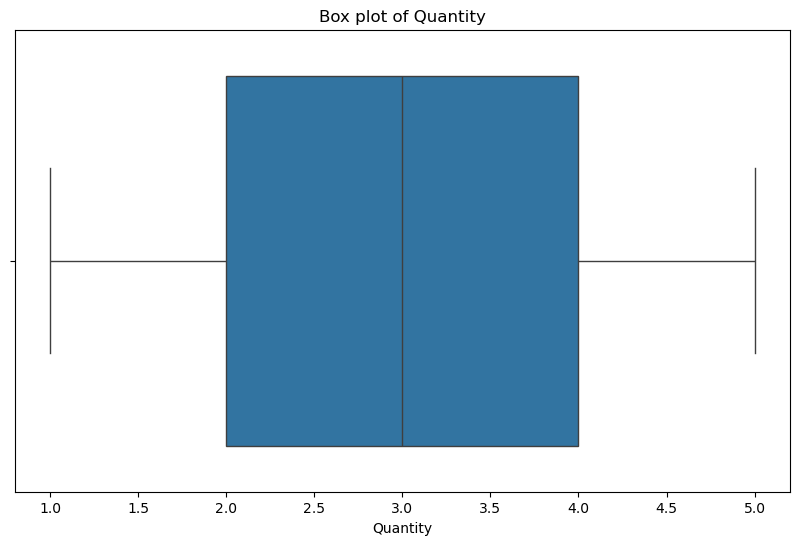

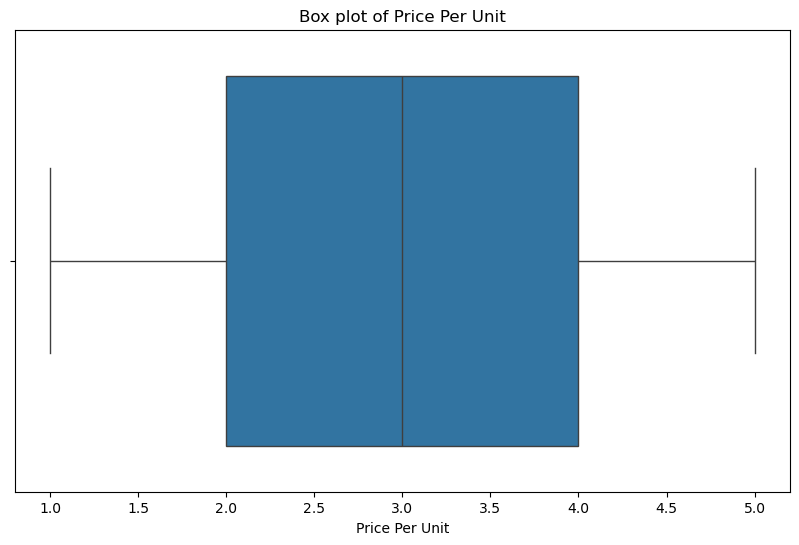

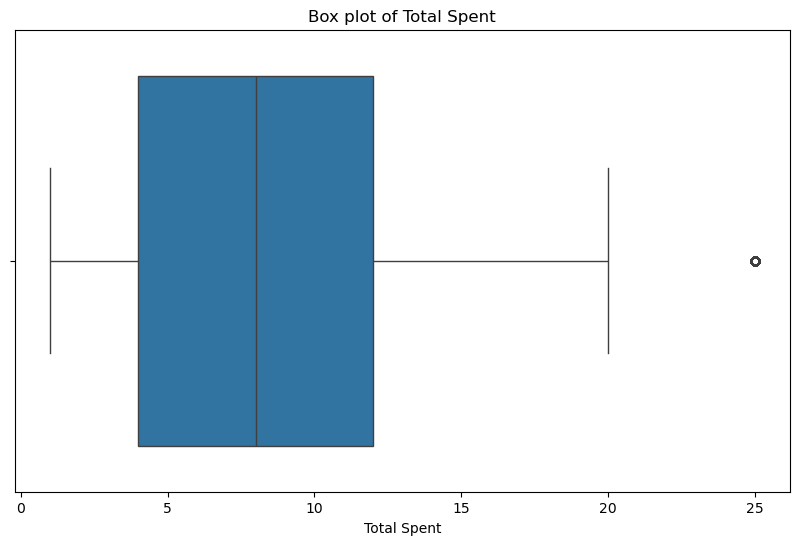

In [166]:
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=new_df[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

In [167]:
# Contoh sederhana untuk mengidentifikasi outliers menggunakan IQR
Q1 = new_df[numeric_features].quantile(0.25)
Q3 = new_df[numeric_features].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Quantity          2.0
Price Per Unit    2.0
Total Spent       8.0
dtype: float64


In [168]:
# Filter dataframe untuk hanya menyimpan baris yang tidak mengandung outliers pada kolom numerik
condition = ~((new_df[numeric_features] < (Q1 - 1.5 * IQR)) | (new_df[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)
df_filtered_numeric = new_df.loc[condition, numeric_features]

In [169]:
# Menggabungkan kembali dengan kolom kategorikal
categorical_features = new_df.select_dtypes(include=['object']).columns
new_df = pd.concat([df_filtered_numeric, new_df.loc[condition, categorical_features]], axis=1)

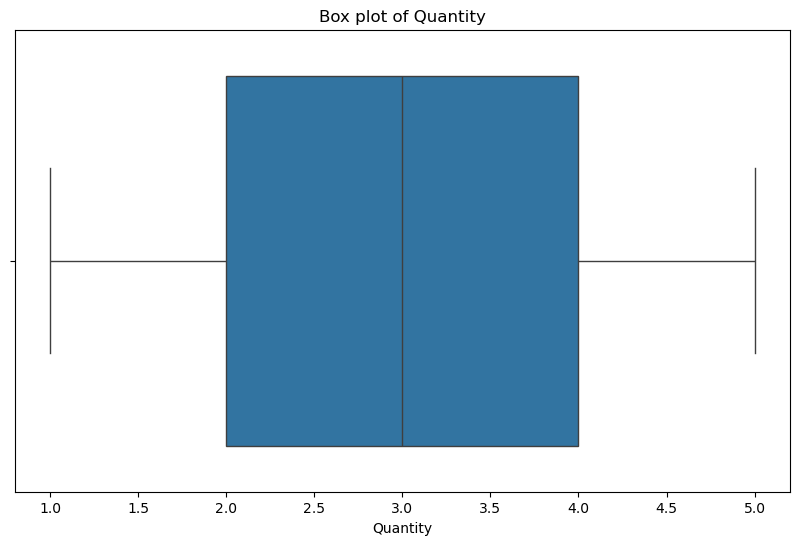

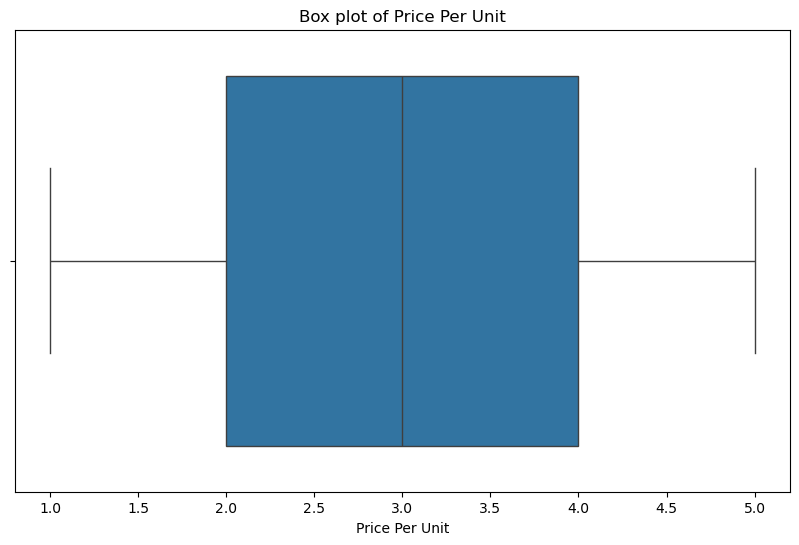

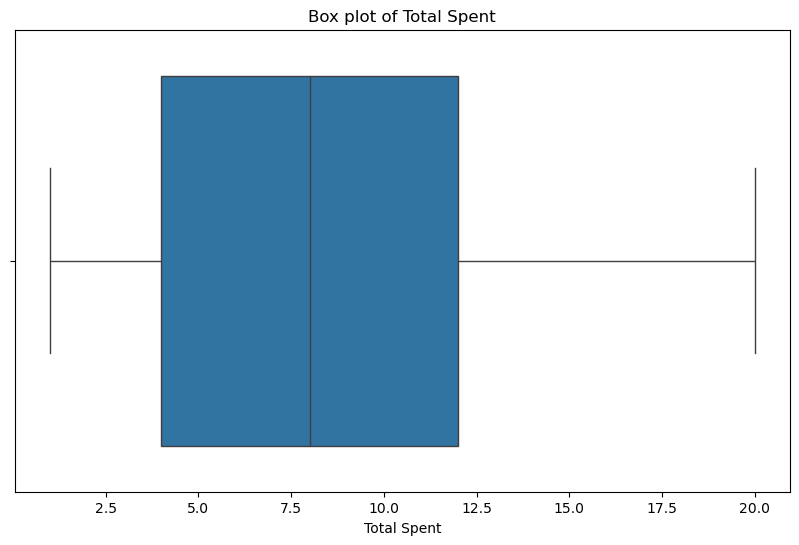

In [170]:
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=new_df[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

# Normalisasi dan Standardisasi Data

In [173]:
# Standardisasi fitur numerik
scaler = StandardScaler()
new_df[numeric_features] = scaler.fit_transform(new_df[numeric_features])

In [175]:
numeric_features

Index(['Quantity', 'Price Per Unit', 'Total Spent'], dtype='object')

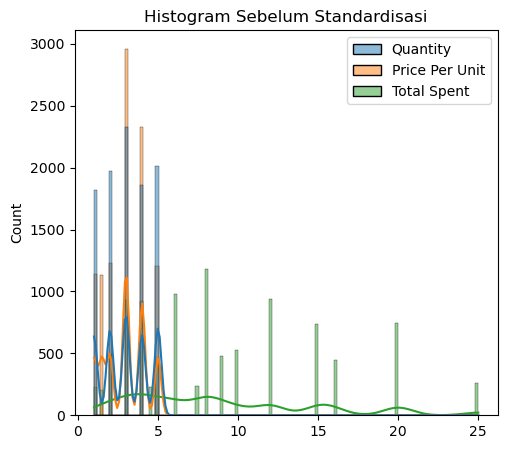

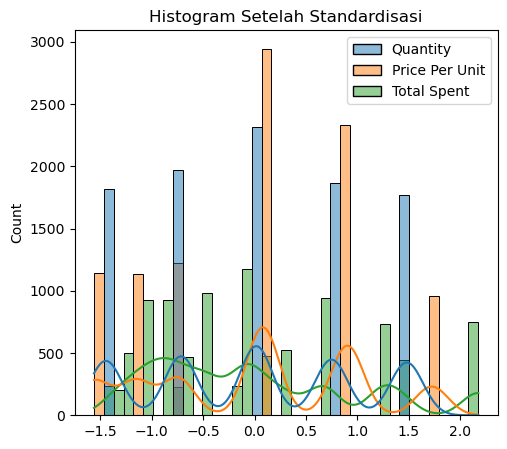

In [182]:
# Histogram Sebelum Standardisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[numeric_features], kde=True)
plt.title("Histogram Sebelum Standardisasi")
plt.show()

# Histogram Sesudah Standardisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.histplot(new_df[numeric_features], kde=True)
plt.title("Histogram Setelah Standardisasi")
plt.show()

# Menangani Duplikasi Data

In [183]:
# Mengidentifikasi baris duplikat
duplicates = new_df.duplicated()
 
print("Baris duplikat:")
print(new_df[duplicates])

Baris duplikat:
Empty DataFrame
Columns: [Quantity, Price Per Unit, Total Spent, Transaction ID, Item, Transaction Date]
Index: []


In [184]:
# Menghapus baris duplikat
new_df = new_df.drop_duplicates()
 
print("DataFrame setelah menghapus duplikat:")
print(new_df)

DataFrame setelah menghapus duplikat:
      Quantity  Price Per Unit  Total Spent Transaction ID      Item  \
0    -0.715225       -0.740718    -0.838421    TXN_1961373    Coffee   
1     0.748432        0.080934     0.669095    TXN_4977031      Cake   
2     0.748432       -1.562369    -0.084663    TXN_4271903    Cookie   
3    -0.715225        1.724236     0.292216    TXN_7034554     Salad   
4    -0.715225       -0.740718    -0.838421    TXN_3160411    Coffee   
...        ...             ...          ...            ...       ...   
9995 -0.715225       -0.740718    -0.838421    TXN_7672686    Coffee   
9996  0.016603        0.080934    -1.026861    TXN_9659401     Juice   
9997  0.748432       -0.740718    -0.084663    TXN_5255387    Coffee   
9998  0.016603        0.080934    -1.026861    TXN_7695629    Cookie   
9999  0.016603        0.902585     0.669095    TXN_6170729  Sandwich   

     Transaction Date  
0          2023-09-08  
1          2023-05-16  
2          2023-07-19  
3

# Mengonversi Tipe Data

In [ ]:
# Seleksi kolom kategorikal
category_features = new_df.select_dtypes(include="object").columns
new_df[category_features]

,Transaction ID,Item,Transaction Date
0,TXN_1961373,Coffee,2023-09-08
1,TXN_4977031,Cake,2023-05-16
2,TXN_4271903,Cookie,2023-07-19
3,TXN_7034554,Salad,2023-04-27
4,TXN_3160411,Coffee,2023-06-11
...,...,...,...
9995,TXN_7672686,Coffee,2023-08-30
9996,TXN_9659401,Juice,2023-06-02
9997,TXN_5255387,Coffee,2023-03-02
9998,TXN_7695629,Cookie,2023-12-02


## One Hot Encoding

In [187]:
# One hot encoding
df_one_hot = pd.get_dummies(new_df, columns=category_features)
df_one_hot

,Quantity,Price Per Unit,Total Spent,Transaction ID_TXN_1000555,Transaction ID_TXN_1001832,Transaction ID_TXN_1002457,Transaction ID_TXN_1003246,Transaction ID_TXN_1004184,Transaction ID_TXN_1004563,Transaction ID_TXN_1005331,...,Transaction Date_2023-12-24,Transaction Date_2023-12-25,Transaction Date_2023-12-26,Transaction Date_2023-12-27,Transaction Date_2023-12-28,Transaction Date_2023-12-29,Transaction Date_2023-12-30,Transaction Date_2023-12-31,Transaction Date_ERROR,Transaction Date_UNKNOWN
0,-0.715225,-0.740718,-0.838421,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.748432,0.080934,0.669095,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.748432,-1.562369,-0.084663,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.715225,1.724236,0.292216,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.715225,-0.740718,-0.838421,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.715225,-0.740718,-0.838421,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,0.016603,0.080934,-1.026861,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,0.748432,-0.740718,-0.084663,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,0.016603,0.080934,-1.026861,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Label Encoding

In [189]:
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()
df_lencoder = pd.DataFrame(new_df)

for col in category_features:
    df_lencoder[col] = label_encoder.fit_transform(new_df[col])
 
# Menampilkan hasil
df_lencoder

,Quantity,Price Per Unit,Total Spent,Transaction ID,Item,Transaction Date
0,-0.715225,-0.740718,-0.838421,1026,1,250
1,0.748432,0.080934,0.669095,4347,0,135
2,0.748432,-1.562369,-0.084663,3597,2,199
3,-0.715225,1.724236,0.292216,6571,5,116
4,-0.715225,-0.740718,-0.838421,2372,1,161
...,...,...,...,...,...,...
9995,-0.715225,-0.740718,-0.838421,7244,1,241
9996,0.016603,0.080934,-1.026861,9363,4,152
9997,0.748432,-0.740718,-0.084663,4643,1,60
9998,0.016603,0.080934,-1.026861,7272,2,335
